In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors

In [2]:
!pip install gensim==3.4.0
!pip install smart_open==1.9.0


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


Embedding 

In [3]:
drug_fp_df =pd.read_csv("/Users/elifozkan/Desktop/translator-openpredict/data/drkg/feature_related/output/drugs-tc-sim.csv")
drug_fp_df= drug_fp_df.pivot(index='Drug1', columns='Drug2', values=['TC'])
drug_fp_df= drug_fp_df.fillna(0.0)

In [4]:
disease_hp_df = pd.read_csv("/Users/elifozkan/Desktop/translator-openpredict/data/drkg/feature_related/output/disease-hpo.csv")
disease_hp_df.head()

,Disease1,Disease2,HPO-SIM
0,MESH:D000163,MESH:D024821,0.0
1,MESH:D000163,MESH:D000310,0.0
2,MESH:D000163,MESH:D000437,0.0
3,MESH:D000163,MESH:D000506,0.0
4,MESH:D000163,MESH:D000544,0.0


In [5]:
disease_hp_df= disease_hp_df.pivot_table(index='Disease1', columns='Disease2', values=['HPO-SIM'],aggfunc='mean')
disease_hp_df= disease_hp_df.fillna(0.0)

In [6]:
def sim_mat2emb_file(sm_df, file_path):
    with open(file_path, 'a') as file:
        file.write(str(sm_df.shape[0])+' '+str(sm_df.shape[1])+'\n')
        sm_df.to_csv(file, sep=' ', header=False)

In [7]:
sim_mat2emb_file(drug_fp_df,'/Users/elifozkan/Desktop/translator-openpredict/data/drkg/feature_related/drugs_fp_embed.txt')
sim_mat2emb_file(disease_hp_df,"/Users/elifozkan/Desktop/translator-openpredict/data/drkg/feature_related/disease_hp_embed.txt")

In [8]:
drug_fp_vectors = KeyedVectors.load_word2vec_format("/Users/elifozkan/Desktop/translator-openpredict/data/drkg/feature_related/drugs_fp_embed.txt", binary=False)

/Users/elifozkan/.pyenv/versions/3.8.13/lib/python3.8/site-packages/smart_open/smart_open_lib.py:400: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  warnings.warn(


In [9]:
drug_fp_vectors.most_similar('DB00104', topn=5)

[('DB00293', 0.9896167516708374),
 ('DB01331', 0.9820491075515747),
 ('DB06365', 0.9806907176971436),
 ('DB07374', 0.9772778749465942),
 ('DB08930', 0.9767699241638184)]

In [10]:
disease_hp_vectors = KeyedVectors.load_word2vec_format("/Users/elifozkan/Desktop/translator-openpredict/data/drkg/feature_related/disease_fp_embed.txt", binary=False)
disease_hp_vectors.most_similar('MESH:D000163',topn=5)

[('MESH:D024821', 0.7525877952575684),
 ('MESH:D002532', 0.7373294234275818),
 ('MESH:D000690', 0.7277084589004517),
 ('MESH:D001172', 0.7206549644470215),
 ('MESH:D003876', 0.7203758358955383)]

In [11]:
indications = pd.read_csv("/Users/elifozkan/Desktop/translator-openpredict/data/drkg/feature_related/output/drug-disease-indications.csv")

Code for embedding generation 

In [12]:
indications_dict = set()
for i, row in indications.iterrows():
    #row['DB_ID'], row['DO_ID']
    pair = (str(row['SubjectID']), str(row['ObjectID']))
    indications_dict.add(pair)

In [13]:
def calculateEntitySimilarities(tokenized_vector, topn = 100) :
    ''' calculates similarity scores of all drug-drug and disease-disease
        pairs that exist in the knowledge base
        return : a list containing all the similarity scores '''

    entities = list(tokenized_vector.vocab)
    similarity_scores = []
    for entity in entities :
        similarEntities = tokenized_vector.most_similar(entity, topn=100)
        for ent, sim in similarEntities :
            similarity_scores.append(1-sim)

    return similarity_scores

In [14]:
def getQuantiles( drug_vectors, disease_vectors, quantile = 0.1) :
    ''' calulcates the nth quantile of the calculated similarity scores
        return : the min-threshold for the drugs and diseases as a tuple
    '''
    drug_similarities = calculateEntitySimilarities(drug_vectors,1853)

    drug_sim_df = pd.DataFrame(drug_similarities)
    #print(drug_sim_df.describe())

    disease_similarities = calculateEntitySimilarities(disease_vectors,120)

    disease_sim_df = pd.DataFrame(disease_similarities)
    return ((drug_sim_df.quantile(quantile)[0]), (disease_sim_df.quantile(quantile)[0]))

In [15]:
def path_weight_summation(g1,drug,disease):
    path_weight = {}
    for path in nx.all_simple_paths(g1,drug,disease, cutoff=4):
        dpath = 0
        for i in range(len(path)-1):
            dpath += g1[path[i]][path[i+1]]['weight']
        path_weight[str(path)] = dpath

    return path_weight

In [16]:
def generate_paths_for_apair(drug, disease, drug_emb_vectors, disease_emb_vectors,features_drug = None, features_disease = None,threshold_drugs = 1,threshold_diseases = 1):
    g = nx.Graph()
    (threshold_drug,threshold_disease) =getQuantiles(drug_emb_vectors, disease_emb_vectors, threshold_drugs)

    if(features_drug is not None) :
         filtered_embedding_drugs = drug_fp_vectors
         similarDrugs = filtered_embedding_drugs.most_similar(drug, topn=100)
         (threshold_drug,threshold_disease) =getQuantiles(filtered_embedding_drugs, disease_emb_vectors, threshold_drugs)
    else :
       similarDrugs = drug_emb_vectors.most_similar(drug, topn=100)


    g.add_node(drug, id=drug,
               name="fake", categories=["biolink:Drug"])
    for dr, sim in similarDrugs:
        if ((1-sim) <= threshold_drug) :
             g.add_node(dr, id=dr,
                   name="fake", categories=["biolink:Drug"])
             g.add_edge(dr, drug, id=dr+drug,
                   predicate="biolink:similar_to", subject=dr, object=drug,  weight=1-sim, attributes={"description": "score",
                                                               "attribute_type_id": "EDAM:data_1772",
                                                               "value": (1-sim)                                                     })
             g.add_node("OMIM:"+disease, id="OMIM:"+disease,
               name="fake", categories=["biolink:Disease"])
    (threshold_drug,threshold_disease) =getQuantiles(drug_emb_vectors, disease_emb_vectors, threshold_diseases)


    # TODO: USE settings.OPENPREDICT_DATA_DIR instead of lucky relative path
    if(features_disease is not None) :
        filtered_embedding_diseases = disease_emb_vectors
        # filtered_embedding_diseases = KeyedVectors.load_word2vec_format(f'openpredict/data/embedding/feature_specific_embeddings_KG/feature_{str(features_disease)}.txt', binary=False)
        similarDiseases = filtered_embedding_diseases.most_similar(disease, topn=100)
        (threshold_drug,threshold_disease) =getQuantiles(drug_fp_vectors, filtered_embedding_diseases, threshold_diseases)
    else :
        similarDiseases = disease_emb_vectors.most_similar(disease, topn=100)


    for ds, sim in similarDiseases:
        if((1-sim) <= threshold_disease) :
             g.add_node(ds, id=ds,
                   name="fake", categories=["biolink:Disease"])
             g.add_edge(ds, disease,
                   id= ds+ disease, predicate="biolink:similar_to", subject= ds, object= disease, weight=1-sim, attributes={"description": "score",
                                                                                                 "attribute_type_id": "EDAM:data_1772",
                                                                                                 "value": 1+(1-sim)
                                                                                                 })

    for (dr, ds) in indications_dict:
        if dr in g.nodes() and ds in g.nodes():
            g.add_edge(dr, ds, id=
                         dr+"_"+ds, predicate="biolink:treats", subject=dr, object= ds,  weight= 1.0,
                                                                                attributes={"description": "score",
                                                                               "attribute_type_id": "EDAM:data_1772",
                                                                               "value": "1.0"
                                                                               })

    return (g)


In [17]:
import ast
def generate_explanation(drug, disease, drug_fp_vectors, disease_hp_vectors,features_drug = None, features_disease = None,threshold_drugs = 0,threshold_disease = 0):
    #-> Path generation, add similar_to relation between query drug and disease
    #-> add known treats relations if any drug-disease pair in the graph has a treats relation
    g1= generate_paths_for_apair(
        drug, disease, drug_fp_vectors, disease_hp_vectors,features_drug, features_disease,threshold_drugs,threshold_disease)
    # Iterate over all simple paths
    # assign a weight to each path by summing their weights (for similar_to weight is 1-similarity, for treats, weight is 1)
    path_weight = path_weight_summation(g1,drug=drug, disease=disease)
    # rank the paths and take only top-K paths
    path_weight_dict = sorted(path_weight.items(), key=lambda x: x[1], )
    # create a final graph by merging the top-K paths
    G = nx.Graph()
    for p, s in path_weight_dict[:100]:
        path = ast.literal_eval(p)
        for i in range(len(path)-1):
            s_node_name = path[i]
            t_node_name = path[i+1]
            edge_data = g1[s_node_name][t_node_name]

            G.add_node(s_node_name, id=drug,
               name="fake", categories=["biolink:Drug"])
            G.add_node(t_node_name, id=drug,
               name="fake", categories=["biolink:Drug"])

            G.add_edge(s_node_name, t_node_name, id = edge_data["id"], predicate= edge_data["predicate"],
            subject = edge_data["subject"], object = edge_data["object"], weight=edge_data["weight"],
            attributes= edge_data["attributes"])

    return G

In [18]:
def generate_json(graph) :
    graph_json ={}
    graph_json['nodes'] = list()

    for node in graph.nodes():
        graph_json['nodes'].append(graph[node])

    graph_json['edges']=list()
    for edge in graph.edges():
        graph_json['edges'].append(graph[edge[0]][edge[1]])

    return graph_json



def do_evidence_path(drug_id: str, disease_id: str, threshold_drugs : float,threshold_disease : float, features_drug, features_disease):
    ''' generates explanations based on the user input and returns a json'''
    evidence_path = generate_explanation(drug=drug_id, disease=disease_id, drug_fp_vectors = drug_fp_vectors, disease_hp_vectors= disease_hp_vectors,
                                         features_drug = features_drug, features_disease = features_disease,threshold_drugs = threshold_drugs,threshold_disease = threshold_disease )
    return generate_json(evidence_path)

Use case : Alzheimer's Disease 

In [19]:
drug = "DB01043"
disease = "MESH:D000544"

In [20]:
do_evidence_path(drug,disease,0.00,0.005,None,None)

{'nodes': [AtlasView({'MESH:D000544': {'id': 'DB01043_MESH:D000544', 'predicate': 'biolink:treats', 'subject': 'DB01043', 'object': 'MESH:D000544', 'weight': 1.0, 'attributes': {'description': 'score', 'attribute_type_id': 'EDAM:data_1772', 'value': '1.0'}}}),
  AtlasView({'DB01043': {'id': 'DB01043_MESH:D000544', 'predicate': 'biolink:treats', 'subject': 'DB01043', 'object': 'MESH:D000544', 'weight': 1.0, 'attributes': {'description': 'score', 'attribute_type_id': 'EDAM:data_1772', 'value': '1.0'}}})],
 'edges': [{'id': 'DB01043_MESH:D000544',
   'predicate': 'biolink:treats',
   'subject': 'DB01043',
   'object': 'MESH:D000544',
   'weight': 1.0,
   'attributes': {'description': 'score',
    'attribute_type_id': 'EDAM:data_1772',
    'value': '1.0'}}]}

In [21]:
evidence_path = generate_explanation(drug=drug, disease=disease, drug_fp_vectors = drug_fp_vectors, disease_hp_vectors= disease_hp_vectors,
                                         features_drug = None, features_disease = None,threshold_drugs = 0.5,threshold_disease = 0.1)

In [22]:
evidence_path.nodes()

NodeView(('DB01043', 'MESH:D000544', 'DB00472', 'DB00981', 'DB08839', 'MESH:D050197', 'DB00295', 'MESH:D001859', 'DB00661', 'MESH:D002311', 'DB01388', 'MESH:D005910', 'DB00297', 'MESH:D003093', 'DB00379', 'MESH:D001172', 'DB00608'))

In [24]:
def remove_graph(target_drug,target_disease,evidence_path): 
    nodes = evidence_path.nodes()

    nodes_to_remove = []
    for node in nodes: 
        if (node != target_drug) or (node != target_disease): 
            nodes_to_remove.append(node)
    return nodes_to_remove

nodes_to_remove= remove_graph(drug,disease,evidence_path)
type(evidence_path)

networkx.classes.graph.Graph

In [25]:
imp_node_dict = {}
compound_list = []
disease_list = []
for i in range(0,len(nodes_to_remove)):
    if("DB" in nodes_to_remove[i]):
        compound_list.append(nodes_to_remove[i])
    else: 
        disease_list.append(nodes_to_remove[i])

imp_node_dict["Compound"] = compound_list
imp_node_dict["Disease"] = disease_list

Map entity ids with names 

In [112]:
nodes = evidence_path.nodes()
drugbank_vocab = pd.read_csv("/Users/elifozkan/Desktop/GNNExplanations/db_mesh_names/drugbank vocabulary.csv")

entity_dict = {}

for node in nodes : 
    if(node.startswith("DB")):
        entity_dict.update({node : drugbank_vocab.loc[drugbank_vocab["DrugBank ID"] == node]["Common name"]}) 

mesh_vocab = pd.read_csv("/Users/elifozkan/Desktop/GNNExplanations/db_mesh_names/MESH_diseases_vocab.tsv", sep = "\t")
mesh_vocab["d"] = mesh_vocab["d"].str.upper()

for node in nodes : 
    if node.startswith("MESH"):
        entity_dict.update({node : mesh_vocab.loc[mesh_vocab["d"] == node]["name"]}) 
entity_dict

for key in entity_dict: 
    entity_dict[key] = "".join([i for i in str(entity_dict[key]) if not i.isdigit()])
    entity_dict[key] = entity_dict[key].replace("\nName: Common name, dtype: object", "")
    entity_dict[key] = entity_dict[key].replace("\nName: name, dtype: object","")
    entity_dict[key] = entity_dict[key].replace("    ","")
    entity_dict[key] = key+"\n"+entity_dict[key]
entity_dict

{'DB01043': 'DB01043\nMemantine',
 'DB00982': 'DB00982\nIsotretinoin',
 'DB00970': 'DB00970\nDactinomycin',
 'DB08839': 'DB08839\nSerotonin',
 'DB00190': 'DB00190\nCarbidopa',
 'DB00661': 'DB00661\nVerapamil',
 'DB00515': 'DB00515\nCisplatin',
 'DB00297': 'DB00297\nBupivacaine',
 'DB00379': 'DB00379\nMexiletine',
 'DB00608': 'DB00608\nChloroquine',
 'MESH:D000544': 'MESH:D000544\nAlzheimer Disease',
 'MESH:D003704': 'MESH:D003704\nDementia',
 'MESH:D010302': 'MESH:D010302\nParkinson Disease, Secondary',
 'MESH:D004827': 'MESH:D004827\nEpilepsy',
 'MESH:D005910': 'MESH:D005910\nGlioma',
 'MESH:D003093': 'MESH:D003093\nColitis, Ulcerative',
 'MESH:D001172': 'MESH:D001172\nArthritis, Rheumatoid'}

In [113]:
import dgl
dgl_graph = dgl.from_networkx(evidence_path)
from dgl.data.utils import save_graphs
save_graphs("./evidence_path.bin", dgl_graph)

Visualize the explanatory graph

In [114]:
import matplotlib.patches as mpatches
import matplotlib as plt
color = ['orangered', 'lightgreen', 'darkorange', 'skyblue', 'lightcyan', 'darkviolet']
label = ['Target Link', 'Anatomy', 'Compound', 'Disease', 'Gene', 'Pharmacologic Class']
#patches = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=color[i], label="{:s}".format(label[i]))[0] for i in
#            range(len(label))]
#plt.show()

In [115]:
import json
with open("Input/entity_dictionary_alzheimer.json") as file:
    entity_dictionary = json.load(file)

In [116]:
labels = entity_dict

In [117]:
edge_labels = {}
for edge in evidence_path.edges(): 
    if(edge[0].startswith("DB") & edge[1].startswith("DB")): 
        edge_labels[edge] = "similar_to"
    elif(edge[0].startswith("MESH") & edge[1].startswith("MESH")): 
        edge_labels[edge] = "similar_to"
    else:
        edge_labels[edge] = "treats"

In [118]:
node_color = []
for node in evidence_path:
        if (node.startswith(drug)) | (node.startswith(disease)): 
             node_color.append("orangered")
        elif node.startswith('DB'):
            node_color.append('darkorange')
        elif node.startswith('MESH'):
            node_color.append('darkviolet')

In [119]:
edge_label_target = {('DB01043', 'MESH:D000544'):"Compound treats the disease"}

In [120]:
import matplotlib.pyplot as plt

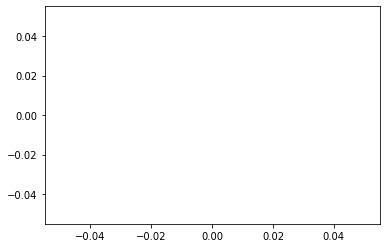

In [124]:
import matplotlib.patches as mpatches
color = ['orangered',  'darkorange', 'darkviolet']
label = ['Target Link', 'Compound', 'Disease']
patches = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=color[i], label="{:s}".format(label[i]))[0] for i in range(len(label))]

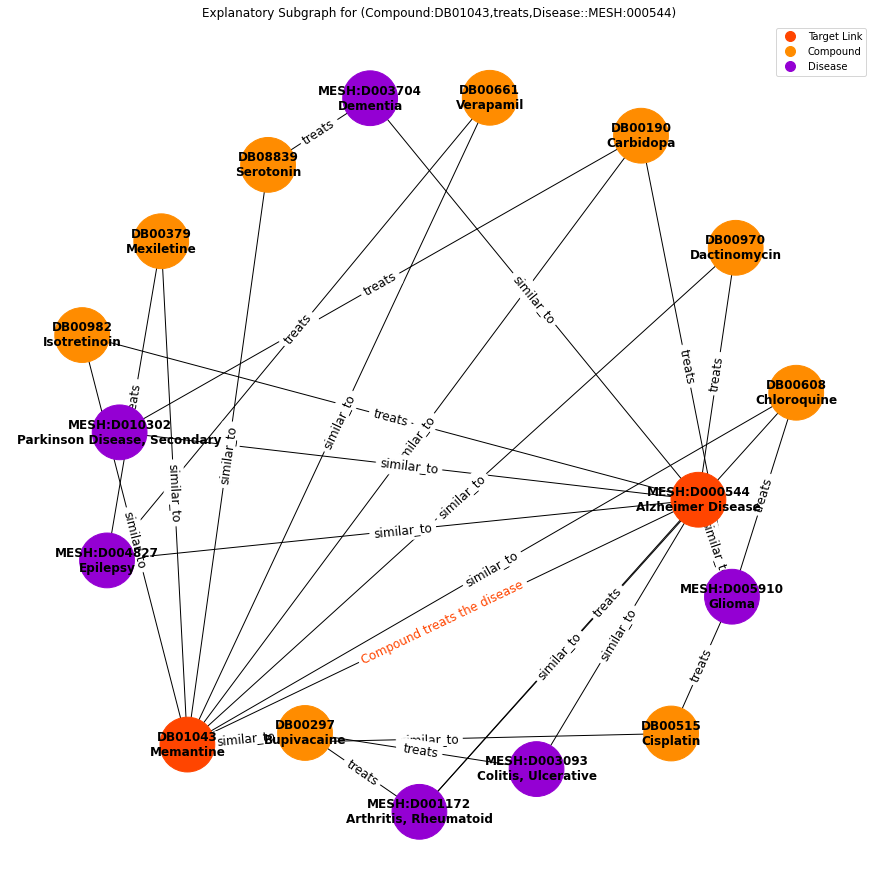

In [125]:

plt.figure(figsize = (12, 12))
pos = nx.spring_layout(evidence_path, k = 2.5)
nx.draw(evidence_path, with_labels=True, node_color=node_color, node_size=3000, pos=pos, font_weight='bold', font_size=12, labels=labels)
nx.draw_networkx_edge_labels(evidence_path, pos, edge_labels=edge_labels, font_color='black', font_size=12)
nx.draw_networkx_edge_labels(evidence_path, pos, edge_labels=edge_label_target, font_color='orangered', font_size=12)
plt.title(f'Explanatory Subgraph for (Compound:DB01043,treats,Disease::MESH:000544)')
plt.legend(handles = patches)
plt.show()

Evaluation of the generated explanations 


- Fidelity- : give only the explanation graph to the model. 
- Fidelity+ : remove explanation from the input. 